# Trotter simulation of a 5-plaqutte system

In [1]:
import numpy as np
import matplotlib.pyplot as plt
try:
    import jax.numpy as jnp
    from jax.scipy.linalg import expm
except ImportError:
    jnp = np
    from scipy.linalg import expm
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as AerEstimator
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from heavyhex_qft.rectangular_z2 import RectangularZ2Lattice
from heavyhex_qft.utils import subspace_projection

use_simulator = True

In [2]:
lattice = RectangularZ2Lattice('''
****
****
***
''')

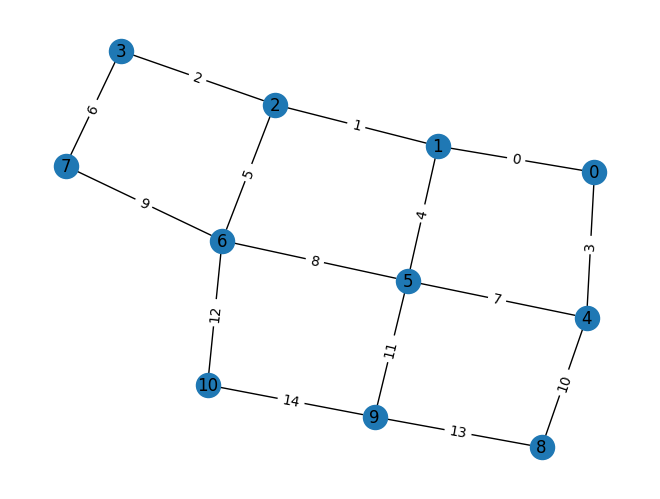

In [3]:
lattice.draw_graph()

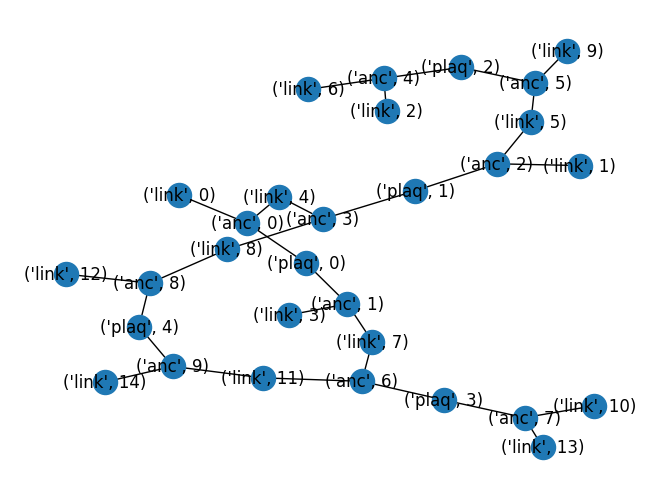

In [4]:
lattice.draw_qubit_graph()

## Start with an initial state with a single link excitation and evolve for 10 steps

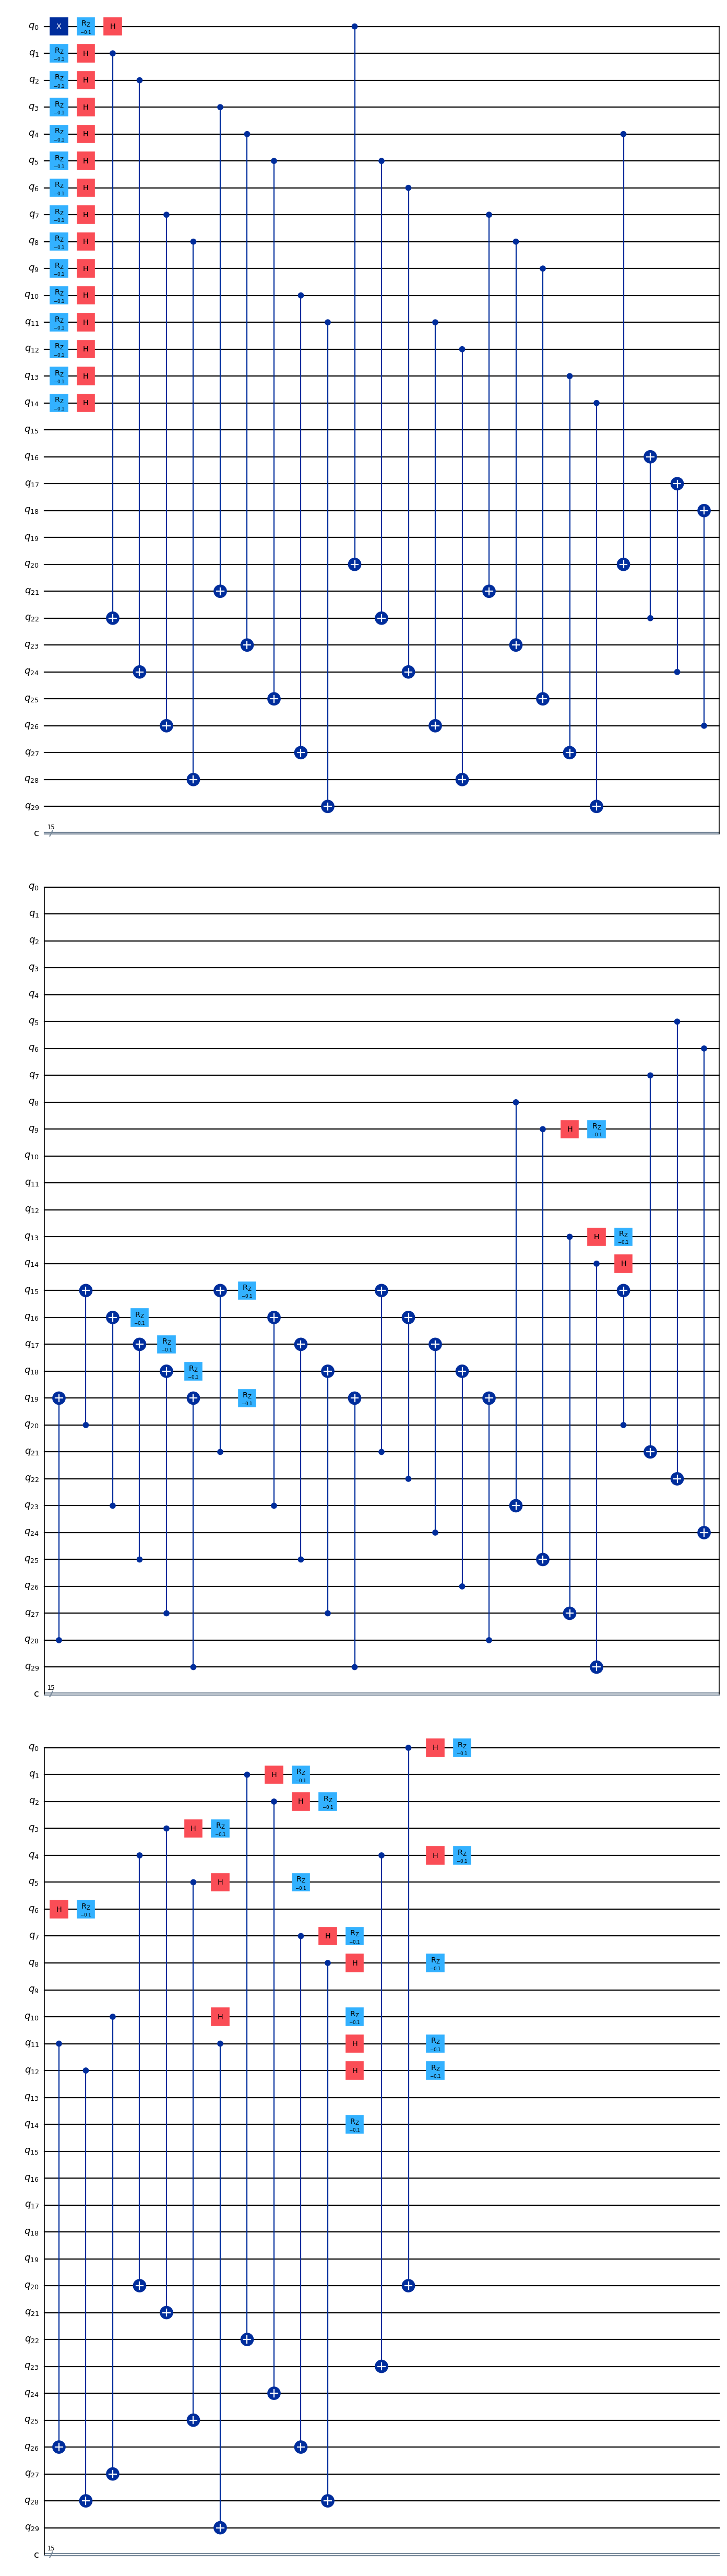

In [5]:
K = 0.5
delta_t = 0.1

snapshots = []

circuit = QuantumCircuit(lattice.qubit_graph.num_nodes(), lattice.num_links)
circuit.x(0)
for _ in range(10):
    circuit.compose(lattice.electric_evolution(0.5 * delta_t), inplace=True)
    circuit.compose(lattice.magnetic_evolution(K, delta_t), inplace=True)
    circuit.compose(lattice.electric_evolution(0.5 * delta_t), inplace=True)
    snapshots.append(circuit.copy())

snapshots[0].draw('mpl', scale=0.8)

## Map to a backend and transpile

In [6]:
if not use_simulator:
    service = QiskitRuntimeService(channel='ibm_quantum')
    backend = service.backend('ibm_fez')

In [7]:
if use_simulator:
    circuits = snapshots
else:
    # Generate the physical-qubit layout for the transpiler (map link 0 to qubit 84)
    layout = lattice.layout_heavy_hex(backend.coupling_map, 84)
    circuits = transpile(snapshots, backend=backend, initial_layout=layout)

# Monitoring the plaquette expectation values
observables = [
    SparsePauliOp(
        lattice.to_pauli({lid: 'X' for lid in lattice.plaquette_links(plid)}, pad_to_nq=True)
    ).apply_layout(circuits[0].layout)
    for plid in range(lattice.num_plaquettes)
]

## Exact diagonalization

In [8]:
hamiltonian_op = lattice.make_hamiltonian(K)
observables_links = [
    SparsePauliOp(
        lattice.to_pauli({lid: 'X' for lid in lattice.plaquette_links(plid)})
    )
    for plid in range(lattice.num_plaquettes)
]

# Taking the initial state where link 0 is excited -> Charge subspace is +1 for vertices 0 and 1
subspace = lattice.charge_subspace([1, 1] + [0] * (lattice.num_vertices - 2))

plaquettes = np.array([subspace_projection(obs, subspace) for obs in observables_links])
initial_state = np.zeros_like(subspace, dtype=complex)
initial_state[np.argwhere(subspace == 1)[0]] = 1.

### Full analytic

In [9]:
hamiltonian = jnp.asarray(subspace_projection(hamiltonian_op, subspace))
times = jnp.linspace(delta_t, delta_t * 10., 100)
ev = expm(-1.j * hamiltonian[None, ...] * times[:, None, None])
states = jnp.einsum('tij,j->ti', ev, initial_state)
evs_analytic = jnp.einsum('ti,pij,tj->tp', states.conjugate(), plaquettes, states).real

### Trotter

In [10]:
hamiltonian_m = subspace_projection(SparsePauliOp(hamiltonian_op.paulis[lattice.num_links:], [-K] * lattice.num_plaquettes), subspace)
hamiltonian_e = subspace_projection(SparsePauliOp(hamiltonian_op.paulis[:lattice.num_links], [-1.] * lattice.num_links), subspace)
ev_m = expm(-1.j * hamiltonian_m * delta_t)
ev_e = expm(-0.5j * hamiltonian_e * delta_t)
times_tr = jnp.arange(1, 11) * delta_t
state = initial_state
states_tr = []
for _ in range(10):
    state = ev_e @ ev_m @ ev_e @ state
    states_tr.append(state)
states_tr = jnp.array(states_tr)
evs_tr = jnp.einsum('ti,pij,tj->tp', states_tr.conjugate(), plaquettes, states_tr).real

## Estimator job

In [12]:
if use_simulator:
    estimator = AerEstimator()
else:
    estimator = Estimator(backend)

estimator_result = estimator.run([(circuit, observables) for circuit in circuits]).result()

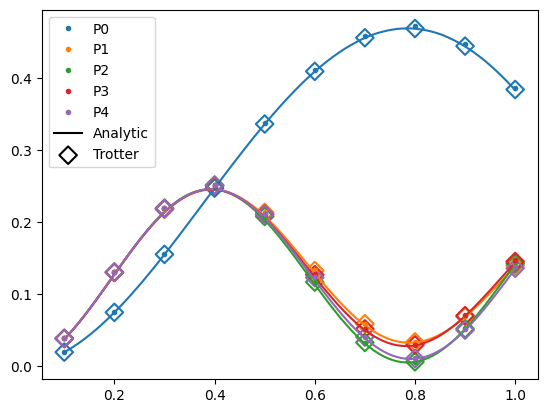

In [13]:
from matplotlib.markers import MarkerStyle
from matplotlib.lines import Line2D
from matplotlib.collections import PathCollection

evs = np.array([res.data.evs for res in estimator_result])
stds = np.array([res.data.stds for res in estimator_result])
keys_est = []
marker_tr = MarkerStyle('D', fillstyle='none')
for ip in range(lattice.num_plaquettes):
    path, _, _ = plt.errorbar(times_tr, evs[:, ip], yerr=stds[:, ip], fmt='.', linestyle='none')
    keys_est.append(path)
    line, = plt.plot(times, evs_analytic[:, ip], color=path.get_color())
    markers = plt.scatter(times_tr, evs_tr[:, ip], s=80., c=path.get_color(), marker=marker_tr)

key_analytic = Line2D([], [])
key_analytic.update_from(line)
key_analytic.set_color('black')
key_tr = PathCollection(markers.get_paths())
key_tr.update_from(markers)
key_tr.set_color('black')
key_tr.set_sizes(markers.get_sizes())
key_tr.set_facecolor('none')
plt.legend(keys_est + [key_analytic, key_tr],
           [f'P{ip}' for ip in range(lattice.num_plaquettes)] + ['Analytic', 'Trotter']);